In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 150

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_sheet
from peripodial.anisotropy import angle_distribution

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


Text(0, 0.5, 'D-V axis')

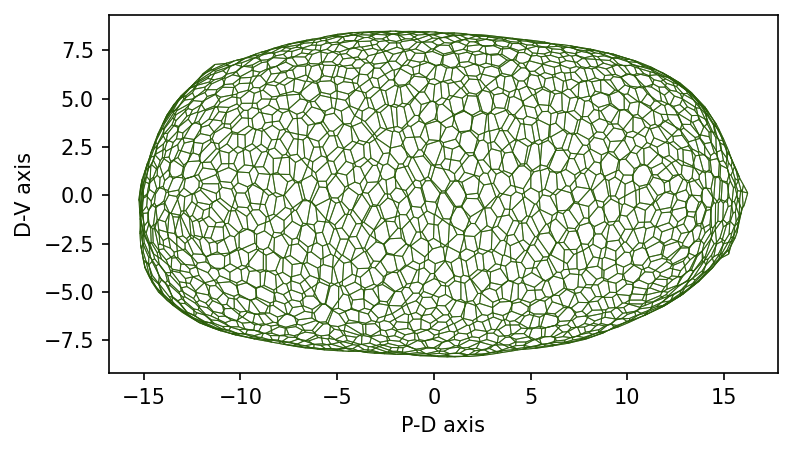

In [4]:
fig, ax = sheet_view(sheet, coords=["z", "x"])
ax.set_xlabel('P-D axis')
ax.set_ylabel('D-V axis')


In [5]:
sheet.settings

{'geometry': 'spherical',
 'height_axis': 'z',
 'lumen_prefered_vol': 5600,
 'lumen_vol_elasticity': 0.0001,
 'threshold_length': 0.01,
 'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
 'barrier_radius': 100,
 'lumen_vol': 5036.342457882481}

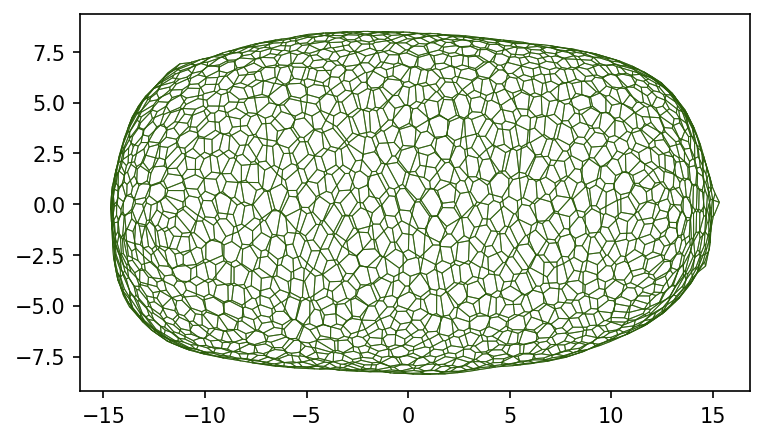

In [6]:
specs['settings']["barrier_radius"] = 12.5
specs['vert']["barrier_elasticity"] = 1e-2
specs['settings']["barrier_radius"] = 14
specs['face']["perimeter_elasticity"] = 0.1

sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [7]:
#### verify that the function update_weight works
"""change = []
sheet_copy = sheet.copy()
theta = np.pi / 3

for i in range(10): 
    
    print(f"{i+1} / 10", end=" ")
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1.0,
    )
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)


sheet_copy1 = sheet_copy.copy()
sheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] 

draw_specs = {'vert': {
            'visible': False
            },
        'edge': {
            'color': sheet_copy1.edge_df["weight"],
            'colormap': "coolwarm",
            'width': sheet_copy1.edge_df["weight"]
            #'zorder': depth.values
            }
        }

fig, ax = sheet_view(sheet_copy1, ["z", "x"], mode='2D', **draw_specs)
ax.set_facecolor('#101010')
print(change)"""


'change = []\nsheet_copy = sheet.copy()\ntheta = np.pi / 3\n\nfor i in range(10): \n    \n    print(f"{i+1} / 10", end=" ")\n    z_orientation = update_weights(\n        sheet_copy, \n        threshold_angle=theta, \n        below_threshold=0.5,\n        above_threshold=1.0,\n    )\n    solver = QSSolver(with_t1=False, with_t3=False)\n    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})\n    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)\n\n\nsheet_copy1 = sheet_copy.copy()\nsheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] \n\ndraw_specs = {\'vert\': {\n            \'visible\': False\n            },\n        \'edge\': {\n            \'color\': sheet_copy1.edge_df["weight"],\n            \'colormap\': "coolwarm",\n            \'width\': sheet_copy1.edge_df["weight"]\n            #\'zorder\': depth.values\n            }\n        }\n\nfig, ax = sheet_view(sheet_copy1, ["z", "x"], mode=\'2D\', **draw_specs)\nax.set_fac

In [8]:
aniso(sheet, coords = ['x','y','z'])

face
0       1.327190
1       1.693153
2       1.526080
3       1.524434
4       1.702628
          ...   
1647    2.018507
1648    1.329504
1649    1.760510
1650    1.372768
1651    1.164034
Name: anisotropy, Length: 1652, dtype: float64

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


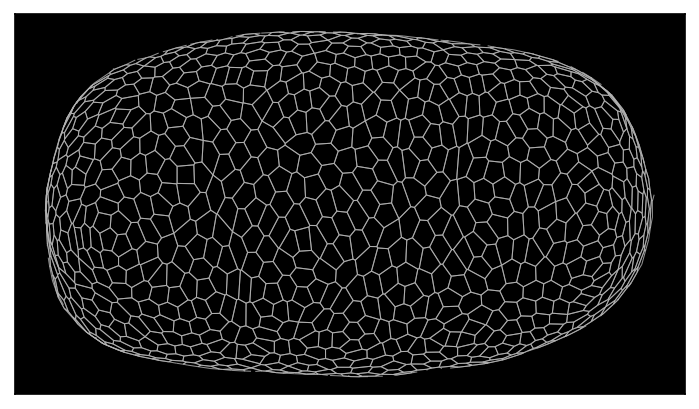

In [9]:
fig, ax = draw_half_sheet(sheet, ax=None)
ax.set_facecolor("black")

In [10]:
sheets_obj = {}
aniso_cell_values_d = []
angle_vs = []
theta = np.pi / 3
bts = np.linspace(0.0, 1.0, 12)[::-1]
angle_vs = []

for i, below_threshold in enumerate(bts):
    
    print(f"{i+1}/{bts.size}", end=" ")

    sheet_copy = sheet.copy()
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=below_threshold,
        above_threshold=1,
    )
    # add some position noise to avoid being stuck in a local min
    sheet_copy.vert_df[['x', 'y', 'z']] += np.random.normal(0.0, 1e-4, (sheet.Nv, 3))
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    print(res.success)


    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=below_threshold,
        above_threshold=1,
    )
    angle_v = np.arcsin(z_orientation)
    angle_degrees = np.degrees(angle_v)
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    angle_vs.append(angle_degrees)
    sheets_obj[below_threshold] = sheet_copy




print(angle_degrees)


1/12 True
2/12 True
3/12 True
4/12 True
5/12 True
6/12 True
7/12 True
8/12 True
9/12 True
10/12 True
11/12 True
12/12 False
edge
0       37.259064
1       84.969655
2       24.251736
3       51.158537
4       14.432816
          ...    
9895    43.427301
9896    57.535446
9897    57.535446
9898     6.069253
9899     6.069253
Length: 9900, dtype: float64


Il n'y a pas de différence significative entre les moyennes des deux populations.


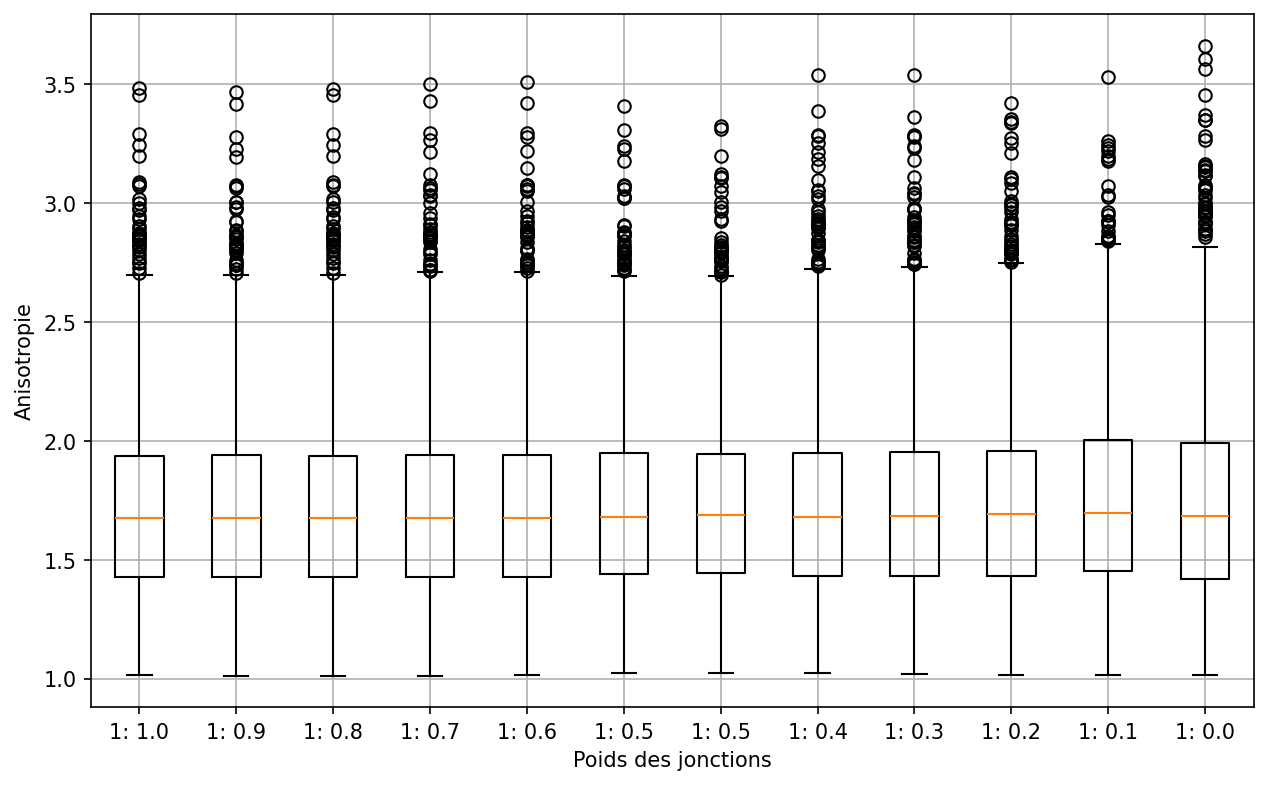

In [18]:
plt.figure(figsize=(10, 6))
bp = plt.boxplot(aniso_cell_values_d, patch_artist=False)
plt.xlabel('Poids des jonctions')
plt.ylabel('Anisotropie')
plt.xticks(range(1, len(bts) + 1), ['1: {:.1f}'.format(i) for i in bts])
plt.grid(True)

# Performing the t-test
statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[11])

# Printing the test results
if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1  # Adjusted for the range of xticks
    x_pos2 = 12
    y_pos = max(max(aniso_cell_values_d[0]), max(aniso_cell_values_d[-1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    
    # Adding significance stars
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '******', ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*****', ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****', ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***', ha='center')

# Save the plot
plt.savefig('../image/plot_aniso_x_position.png', transparent=False)
plt.show()

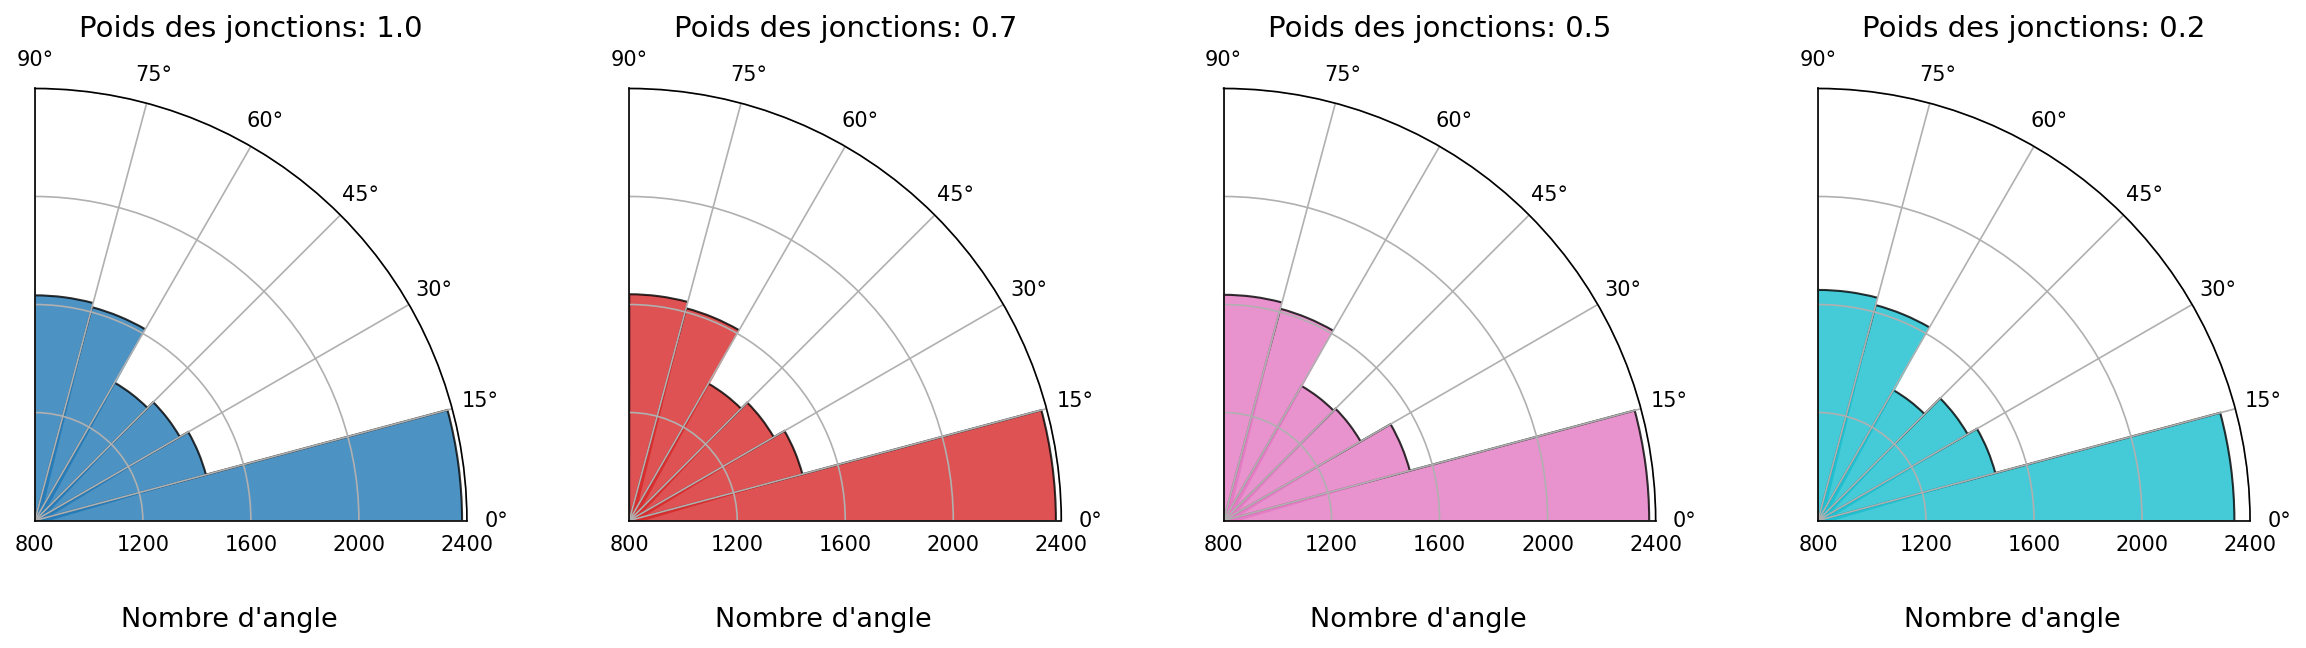

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Définir le nombre de subplots fixe à 4
num_plots = 4

# Créer les subplots
fig, axs = plt.subplots(1, num_plots, figsize=(16, 4), subplot_kw=dict(polar=True))

# Itérer sur les objets angle_vs avec un pas de 4
for i in range(0, min(len(angle_vs), 4*num_plots), 3):
    data = angle_vs[i]
    ax = axs[i // 3]
    ax.hist(np.radians(data), bins=6, color='C{}'.format(i), alpha=0.8, edgecolor='black')
    ax.set_title('Poids des jonctions: {:.1f}'.format(bts[i]), fontsize=14)
    ax.set_xlim(0, np.pi / 2)
    ax.set_ylim(800, 2400)
    ax.set_yticks([800, 1200, 1600, 2000, 2400])  # Définir les positions des marqueurs sur l'axe y
    ax.set_yticklabels(['800', '1200', '1600', '2000', '2400'])  # Définir les étiquettes correspondantes
    ax.set_xlabel("Nombre d'angle", fontsize=13)
    ax.xaxis.set_label_coords(0.45, -0.2)
plt.tight_layout()

plt.savefig('../image/plot_distribution_angle.png', transparent=False)

# Affichage
plt.show()

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


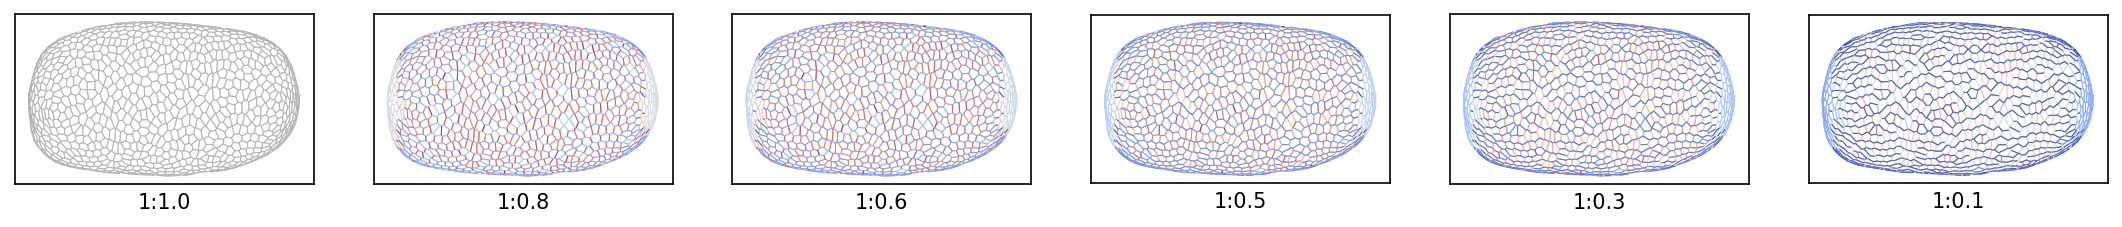

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, (len(sheets_obj) + 1) // 2, figsize=(28, 8))

for i, (above_threshold, sheet_copy) in enumerate(sheets_obj.items()):
    if i % 2 == 0: 
        ax = axes[i // 2]
        fig, ax = draw_half_sheet(sheet_copy, ax)
        ax.set_xlabel('1:{:.1f}'.format(bts[i]))
        ax.set_facecolor("white")

fig.set_size_inches(18, 5)
plt.savefig('../image/aniso_weight.png', transparent=False)
plt.show()



In [ ]:
"""from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/polarity.hdf5",sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/polarity.json", overwrite=True)"""